<a href="https://colab.research.google.com/github/mrharoon-at-berkeley/projects/blob/master/Copy_of_%5BFall_2023%5D_HW2_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2: Resnet

Credit: Sohom Paul, Saathvik Selvan, Aryan Jain

In lecture you've seen a history of neural network architectures. In this notebook, we will be implementing one of the most important CNN architectures of the past few years - the ResNet.

For further refernce on ResNet, you can refer to the [original paper](https://arxiv.org/pdf/1512.03385.pdf) or you can read this [fantastic blog post](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8) on the subject.

In [ ]:
import time
import os

import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision import models, datasets

from tqdm.notebook import tqdm

import numpy as np
from matplotlib import pyplot as plt
from random import randint

### Part 1: Loading the Data

Recall that `torchvision` gives us direct access to common datasets, which saves us from downloading the data ourselves and writing a custom `DataLoader`. This is really handy for when you're doing some quick prototyping or doing research. We will be using the classic CIFAR-10 dataset. This function may take a few seconds to run because it needs to download the dataset from the internet.

In [ ]:
batch_size = 32
data_root = './data/cifar10'
transform = T.Compose([
    T.ToTensor(),
    # scales pixel values to range [-1, 1]
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_size = 40_000
val_size = 10_000

In [ ]:
dataset = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform,
)
assert train_size + val_size <= len(dataset), "Trying to sample too many elements!" \
    "Please lower the train or validation set sizes."
train_set, val_set, _ = torch.utils.data.random_split(
    dataset, [train_size, val_size, len(dataset) - train_size - val_size]
)
classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck',
)

100%|██████████| 170498071/170498071 [00:04<00:00, 40142250.29it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

showing training images


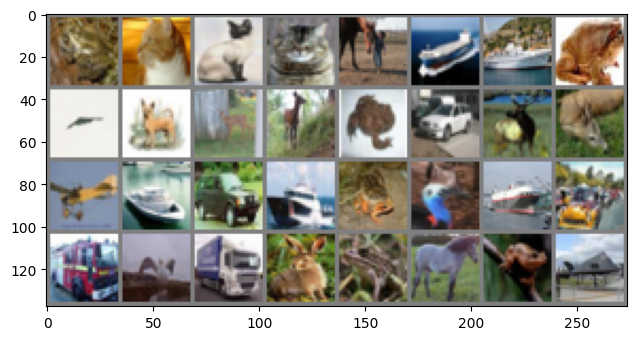


... and their corresponding labels
frog     cat      cat      cat      horse    ship     ship     frog    
plane    dog      deer     deer     frog     car      deer     deer    
plane    ship     car      ship     frog     bird     ship     car     
truck    bird     truck    deer     frog     horse    frog     plane   


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7.5, 7.5]

def show_image(img):
    img = img / 2 + 0.5
    img = img.numpy()
    img = img.transpose([1, 2, 0])
    plt.imshow(img)
    plt.show()

images, labels = next(iter(train_loader))
nrow = 4
print('showing training images')
show_image(torchvision.utils.make_grid(images, nrow=batch_size // nrow))
print('\n... and their corresponding labels')
for idxs in np.array_split(np.arange(batch_size), nrow):
    print(' '.join(f'{classes[labels[j]]:8s}' for j in idxs))

### Part 2: Fully Connected Neural Network

The most basic neural network structure is a fully-connected neural network. This means that every neuron in each layer is connected to every neuron in the previous layer. Let's try implementing one.

In [ ]:
class FCNN(nn.Module):
    def __init__(self, layer_dims):
        '''
        Initialize the torch.nn.Module and define some layers for future use.

        Args:
        layer_dims: list of integers, representing the width of each of the layers of our NN.
                    For simplicity, you may assume that len(layer_dims) == 3
        '''
        super(FCNN, self).__init__()

        # create a list of layers.
        self.layers = nn.ModuleList()

        # Define the fully connected layers based on layer_dims.
        for i in range(1, len(layer_dims)):
            self.layers.append(nn.Linear(layer_dims[i-1], layer_dims[i]))

    def forward(self, x):
        '''
        Compute a forward pass of your batch of images.

        Args:
        x: torch.Tensor of shape (batch_size, num_channels, width, height)

        Returns:
        result of passing x through your network
        '''
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # Flatten the input

        # Apply each of the layers and ReLU activation after each one
        for layer in self.layers:
            x = layer(x)
            x = torch.relu(x)

        return x


Here you will get a chance to implement parts of our training and validation loops. If you find yourself struggling, take a look at the training loop from the first homework -- these loops are usually pretty standard and have many similarities regardless of the model.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def compute_accuracy(model, loader):
    total_correct = 0
    model.to(device)  # Put the model on the specified device (CPU or GPU)
    model.eval()  # Set the model to evaluation mode
    for inputs, labels in tqdm(loader, leave=False):
        inputs, labels = inputs.to(device), labels.to(device)  # Put inputs and labels on the device
        outputs = model(inputs)  # Compute model outputs
        predicted = torch.argmax(outputs, dim=1)  # Get predicted class labels
        total_correct += (predicted == labels).sum().item()  # Count correct predictions
    return total_correct / len(loader.dataset)


def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, path=None, scheduler=None):
    print('Beginning to train model')
    if path and not os.path.exists(path):
        os.makedirs(path)
    model.to(device)  # Put the model on the specified device (CPU or GPU)
    for epoch in tqdm(range(1, num_epochs + 1)):
        model.train()
        total_loss = 0
        start_time = time.perf_counter()
        for inputs, labels in tqdm(train_loader, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)  # Put inputs and labels on the device
            optimizer.zero_grad()  # Zero out the gradients
            outputs = model(inputs)  # Compute model outputs
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Perform an optimizer step
            total_loss += loss.item()  # Update the total loss with the current loss

        if path:
            torch.save(model.state_dict(), f'{path}/model_ep_{epoch:02d}.pth')
        end_time = time.perf_counter()
        duration = end_time - start_time

        train_acc = compute_accuracy(model, train_loader)  # Compute the training accuracy
        val_acc = compute_accuracy(model, val_loader)  # Compute the validation accuracy

        current_lr = optimizer.param_groups[0]['lr']
        if scheduler and current_lr > 5e-5:
            scheduler.step()

        print(f'epoch {epoch:2}',
              f'loss: {total_loss:.3f}',
              f'time: {duration:.3f}',
              f'train acc: {train_acc:.4f}',
              f'val acc: {val_acc:.4f}',
              sep='\t')


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
num_epochs = 15
layer_dims = [3072, 100, 10]
fcnn = FCNN(layer_dims)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fcnn.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
train(fcnn, train_loader, val_loader, num_epochs, criterion, optimizer)

Beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 2379.274	time: 16.464	train acc: 0.4082	val acc: 0.4047


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 2058.333	time: 14.393	train acc: 0.4508	val acc: 0.4388


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 1944.353	time: 15.462	train acc: 0.4788	val acc: 0.4592


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 1873.576	time: 14.320	train acc: 0.5003	val acc: 0.4735


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 1814.557	time: 14.462	train acc: 0.5171	val acc: 0.4789


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 1762.616	time: 14.529	train acc: 0.5312	val acc: 0.4876


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 1716.053	time: 14.535	train acc: 0.5429	val acc: 0.4964


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 1675.140	time: 13.999	train acc: 0.5564	val acc: 0.4961


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 1635.521	time: 15.209	train acc: 0.5676	val acc: 0.5044


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 1601.653	time: 14.245	train acc: 0.5736	val acc: 0.5080


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 1566.930	time: 14.323	train acc: 0.5823	val acc: 0.5077


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 1536.965	time: 13.963	train acc: 0.5969	val acc: 0.5104


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 1508.603	time: 14.319	train acc: 0.5992	val acc: 0.5118


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 1482.237	time: 13.975	train acc: 0.6115	val acc: 0.5112


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 1457.333	time: 13.905	train acc: 0.6174	val acc: 0.5126


As a final observation, let's print the number of parameters that this network learned.

In [ ]:
print(count_parameters(fcnn))

308310


### Part 3: Basic Convolutional Neural Network

You've likely seen in the above example that the validation accuracy of the fully-connected network was not terrible (definitely above the 10% accuracy we'd get from random guessing!), but not too great either.

There are two main issues with fully-connected neural networks. The first is scalability. Because every neuron in each layer is connected to every neuron in the next layer, the number of weights we have in each layer is the product of the sizes of the hidden layers. This means that in order to keep the number of parameters for our model reasonable, we need to either restrict the number of layers or decrease the size of the hidden layers. This prevents us from making very deep fully connected networks that can learn very interesting patterns.

The second issue is that fully connected neural networks are prone to overfitting because they will learn different patterns for each possible pixel in the input image - shifting over the subject of the image by 1 pixel could totally change the output of the network!

These two issues led to the development of the convolutional neural network. The fundamental idea is that instead of connecting all the neurons together, the model instead learns a series of convolutional _kernels_ that it can slide across the image. These kernels make it so that we're applying the same operations to different parts of the image, reducing overfitting, and greatly reduces the number of weights we need, which can improve training time and allow us to train deeper networks.

For more on how CNNs work, check out [this blog post](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) and the lecture slides posted on the course website!

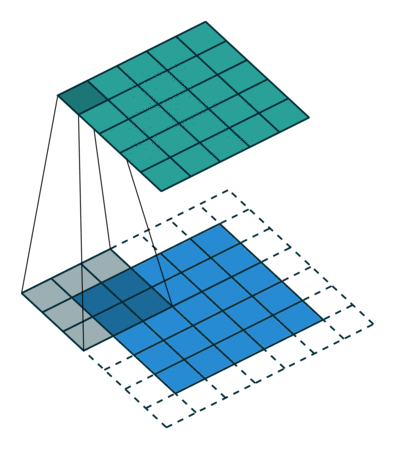

Above: Example convolutional filter. Image courtesy of [Sumit Saha](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).

Now we implement a basic convolutional neural network.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        '''
        Initialize the torch.nn.Module and define some layers for future ues.

        Please use the following network structure:
        - conv layer with 5 output channels and kernel size 5
        - max pooling on 2 by 2 blocks with stride of 2
        - conv layer with 16 output channels and kernel size 5
        - max pooling on 2 by 2 blocks with stride of 2
        - linear (fully-connected) layer with 120 output dims
        - linear (fully-connected) layer with 84 output dims
        - linear (fully-connected) layer with 10 output dims

        After any convolutional or linear layer EXCEPT for the final output,
        we will use a relu activation.
        '''
        ## YOUR CODE HERE
        ## TODO: Define your layers
        super(CNN, self).__init__()

        # Define the layers as specified
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        ## END YOUR CODE

    def forward(self, x):
        '''
        Compute a forward pass of your batch of images. Refer to the docstring
        for the init method for the order in which to call

        x: torch.Tensor of shape (batch_size, num_channels, width, height)
        returns: result of passing x through your network
        '''
        ## YOUR CODE HERE
        ## TODO: Call your convolutional layers, with activation and pooling.
        ## TODO: Flatten your output
        ## TODO: Call your linear layers, with activation.
        ## TODO: Remember NOT to call activation after final fully connected layer!
        x = self.pool1(torch.relu(self.conv1(x)))  # First convolutional layer with activation and pooling
        x = self.pool2(torch.relu(self.conv2(x)))  # Second convolutional layer with activation and pooling
        x = x.view(x.size(0), -1)  # Flatten the output
        x = torch.relu(self.fc1(x))  # First fully connected layer with activation
        x = torch.relu(self.fc2(x))  # Second fully connected layer with activation
        x = self.fc3(x)  # Final fully connected layer (no activation)

        return x
        ## END YOUR CODE

In [ ]:
num_epochs = 15
cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
train(cnn, train_loader, val_loader, num_epochs, criterion, optimizer)

Beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 2786.756	time: 16.258	train acc: 0.2665	val acc: 0.2698


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 2379.686	time: 14.180	train acc: 0.3591	val acc: 0.3509


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 2074.649	time: 14.080	train acc: 0.3866	val acc: 0.3817


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 1907.323	time: 14.411	train acc: 0.4642	val acc: 0.4656


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 1799.871	time: 14.002	train acc: 0.5007	val acc: 0.4992


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 1716.114	time: 14.167	train acc: 0.5205	val acc: 0.5126


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 1645.948	time: 14.050	train acc: 0.5280	val acc: 0.5181


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 1589.259	time: 15.153	train acc: 0.5677	val acc: 0.5529


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 1536.887	time: 14.465	train acc: 0.5774	val acc: 0.5564


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 1492.719	time: 14.185	train acc: 0.5938	val acc: 0.5748


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 1448.495	time: 14.316	train acc: 0.6058	val acc: 0.5690


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 1406.346	time: 14.424	train acc: 0.6206	val acc: 0.5876


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 1373.798	time: 14.086	train acc: 0.6292	val acc: 0.5957


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 1338.614	time: 14.107	train acc: 0.6423	val acc: 0.6028


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 1303.230	time: 15.989	train acc: 0.6600	val acc: 0.6068


In [ ]:
fcnn_num_params = count_parameters(fcnn)
cnn_num_params = count_parameters(cnn)
print('FCNN Num Params:', fcnn_num_params)
print('CNN Num Params:', cnn_num_params)
print('Ratio:', cnn_num_params/fcnn_num_params)

FCNN Num Params: 308310
CNN Num Params: 61530
Ratio: 0.19957185949206968


So we've improved validation accuracy while using 80% fewer parameters. Nice!

### Part 4: Using ResNet for Classification

The network that we're implementing here is here is the residual network (ResNet), a CNN variant and one of the most important networks in modern computer vision.

The fundamental idea behind ResNet is the _skip connection_. In very deep neural networks, we frequently run into the _vanishing gradient problem_, where updates during backpropagation can be multiplied by very small numbers and result in the first few layers of the network learning very slowly. Skip connections rectify this problem by having outputs of some layers jump ahead and skip a few layers and get added in later on. This means that gradient updates have to travel back a shorter distance to update the earlier layers in the network.

The reason that it's called a residual network is because our residual blocks, instead of learning the function $f(x)$, instead learn the _residual_ $f(x) - x$. The input $x$ gets added back in using the skip connection.

For more details, try checking out the [original ResNet paper](https://arxiv.org/pdf/1512.03385.pdf) or [this fantastic blog post](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8).

Because this is a fairly involved architecture, we will only ask you to implement a single residual block of a ResNet18 model.

In [ ]:
class ResNetBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        '''
        Create a residual block for our ResNet18 architecture.

        Here is the expected network structure:
        - conv layer with
            out_channels=out_channels, 3x3 kernel, stride=stride
        - batchnorm layer
        - conv layer with
            out_channels=out_channels, 3x3 kernel, stride=1
        - batchnorm layer
        - shortcut layer:
            if either the stride is not 1 or the out_channels is not equal to in_channels:
                the shortcut layer is composed of two steps:
                - conv layer with
                    in_channels=in_channels, out_channels=out_channels, 3x3 kernel, stride=stride
                - batchnorm layer
            else:
                the shortcut layer should be an no-op

        All conv layers will have a padding of 1 and no bias term. To facilitate this, consider using
        the provided conv() helper function.
        When performing a forward pass, the ReLU activation should be applied after the first batchnorm layer
        and after the second batchnorm gets added to the shortcut.
        '''
        ## YOUR CODE HERE
        ## TODO: Initialize the block with a call to super and make your conv and batchnorm layers.
        ## TODO: Use some conditional logic when defining your shortcut layer
        ## For a no-op layer, consider creating an empty nn.Sequential()
        # Define the convolutional layers and batch normalization
        super().__init__()
        self.conv1 = self.conv(in_channels, out_channels, kernel_size=3, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = self.conv(out_channels, out_channels, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Define the shortcut connection
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                self.conv(in_channels, out_channels, kernel_size=3, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()  # No-op shortcut
        ## END YOUR CODE

    def conv(self, in_channels, out_channels, kernel_size, stride):
        return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1, bias=False)

    def forward(self, x):
        '''
        Compute a forward pass of this batch of data on this residual block.

        x: batch of images of shape (batch_size, num_channels, width, height)
        returns: result of passing x through this block
        '''
        ## YOUR CODE HERE
        ## TODO: Call the first convolution, batchnorm, and activation
        ## TODO: Call the second convolution and batchnorm
        ## TODO: Also call the shortcut layer on the original input
        ## TODO: Sum the result of the shortcut and the result of the second batchnorm
        ## and apply your activation
        # Apply the first convolution, batch normalization, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))

        # Apply the second convolution and batch normalization
        out = self.bn2(self.conv2(out))

        # Apply the shortcut connection and add it to the main path
        out += self.shortcut(x)

        # Apply the ReLU activation
        out = F.relu(out)
        return out

        ## END YOUR CODE

class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=64,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.in_channels = 64
        self.layer1 = self.make_block(out_channels=64, stride=1, rep=2)
        self.layer2 = self.make_block(out_channels=128, stride=2, rep=2)
        self.layer3 = self.make_block(out_channels=256, stride=2, rep=2)
        self.layer4 = self.make_block(out_channels=512, stride=2, rep=2)
        self.linear = nn.Linear(512, num_classes)

    def make_block(self, out_channels, stride, rep):
        layers = []
        for stride in [stride, 1]:
            layers.append(ResNetBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, 4)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

NameError: name 'nn' is not defined

In [ ]:
num_epochs = 15
resnet = ResNet18(num_classes = 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=1e-3, momentum=0.9)

Now that we have defined our model, feel free to use this `torchsummary` package function to visualize how an image is passed through the network and how the layers change the shape of the image. The final convolution layer should output a tensor of size `(32, 512, 4, 4)`, which is averaged, flattened, and passed through a fully connected layer to end up with a `(32, 10)` tensor of classification scores. To evaluate predictions, we simply take the `argmax` of our output.



In [ ]:
resnet = resnet.to(device)
summary(resnet, input_size = (3, 32, 32), batch_size=32)

This model will take about 20 minutes to train. Make sure that you are connected to a GPU runtime for Colab or, if you have GPU on your computer, consider training locally. Watch out for Colab's runtime disconnecting; it shouldn't be a big problem for this homework, but make sure to keep the browser tab open while the models are training.

The staff implementation got a validation accuracy of ~60% after 1 training epoch. If your results are significantly worse than that, consider stopping your training run and debugging your model.

In [ ]:
train(resnet, train_loader, val_loader, num_epochs, criterion, optimizer, 'checkpoints_resnet')

And there we have it! Just by adding these skip connections, we dramatically improved the classification accuracy compared to a vanilla CNN!

### Part 5: Optimizing Hyperparameters and Other Tricks

In this section, you will be trying to achieve a **validation accuracy** of **at least 90%** on the same CIFAR-10 Dataset. Below, we have provided code to allow you to change various properties of your model, training procedure, and dataset augmentation. You are allowed to use whatever you wish except loading in pretrained models. However, creating your own model architecture below using any of the tricks we have learnt in class is fair game.

Here are a couple ideas to get you started:
- Batch size
- Learning rate
- Optimizer
- Loss function
- Learning rate
- Number of epochs
- Image transform
- Different kinds of layers (dropout, batchnorm, etc.)

In [ ]:
import torch
from torchvision import datasets, transforms as T

data_root = './data/cifar10'
train_size = 40000
val_size = 10000

# Modified hyperparameters
batch_size = 32
weight_decay = 1e-4

# Modified data augmentation transforms for training and validation
transform_train = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transform_val = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Create the CIFAR-10 dataset
dataset = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=None,  # Keep this as None for now
)

# Check if the train_size and val_size do not exceed the dataset size
assert train_size + val_size <= len(dataset), "Trying to sample too many elements! " \
    "Please lower the train or validation set sizes."

# Randomly split the dataset into train and validation sets
train_set, val_set, _ = torch.utils.data.random_split(
    dataset, [train_size, val_size, len(dataset) - train_size - val_size]
)

class CustomTransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

# Apply the custom transforms to the train and validation sets
train_set = CustomTransformDataset(train_set, transform=transform_train)
val_set = CustomTransformDataset(val_set, transform=transform_val)

# Create data loaders for training and validation
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,  # Validation data shouldn't be shuffled
    num_workers=2,
)


Files already downloaded and verified


In [ ]:
## YOUR CODE HERE
## TODO: Modify the given hyperparameters
num_epochs = 15
## Feel free to create a bigger resnet model, or use a completely different CNN architecture
## The goal of this problem is for you to apply all of the deep learning tricks we have learnt so far
## to try and maximize the validation accuracy on CIFAR-10 as much as possible.
final_cnn = ResNet18(num_classes = 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(final_cnn.parameters(), lr=1e-3, momentum=0.9, weight_decay=weight_decay)
# TODO: Maybe add a learning rate scheduler?
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=0.1)
## END YOUR CODE

train(final_cnn, train_loader, val_loader, num_epochs, criterion, optimizer, 'checkpoints_final_cnn', scheduler)

Beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 1853.329	time: 54.382	train acc: 0.5804	val acc: 0.5837


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 1302.431	time: 53.581	train acc: 0.6878	val acc: 0.6841


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 1028.675	time: 53.642	train acc: 0.7556	val acc: 0.7393


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 859.920	time: 53.236	train acc: 0.7982	val acc: 0.7796


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 749.177	time: 53.190	train acc: 0.8182	val acc: 0.7969


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 672.620	time: 53.808	train acc: 0.8300	val acc: 0.8123


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 605.420	time: 53.150	train acc: 0.8415	val acc: 0.8235


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 564.654	time: 53.271	train acc: 0.8387	val acc: 0.8119


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 514.311	time: 53.756	train acc: 0.8648	val acc: 0.8350


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 474.307	time: 53.197	train acc: 0.8608	val acc: 0.8267


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 442.062	time: 53.275	train acc: 0.8861	val acc: 0.8499


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 415.028	time: 53.259	train acc: 0.8868	val acc: 0.8543


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 385.119	time: 53.743	train acc: 0.9114	val acc: 0.8737


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 365.123	time: 53.628	train acc: 0.9205	val acc: 0.8778


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 337.681	time: 53.312	train acc: 0.9224	val acc: 0.8812


### Part 6: Autograder and Submission

After you feel confident that you have a decent model, run the cell below.

Feel free to read the code block but **PLEASE DO NOT TOUCH IT**: this will produce a pickle file that will contain your model's predictions on the CIFAR-10 validation set --- tampering with the code block below might mess up the file that you will submit to the Gradescope autograder.

In [ ]:
import pickle

cifar_test = datasets.CIFAR10('.', download = True, train = False, transform = transform_val)
loader_test = DataLoader(cifar_test, batch_size=32, shuffle=False)

final_cnn.eval()  # set model to evaluation mode
predictions = []
with torch.no_grad():
    for x, _ in loader_test:
        x = x.to(device=device)  # move to device, e.g. GPU
        scores = final_cnn(x)
        _, preds = scores.max(1)
        predictions.append(preds)
predictions = torch.cat(predictions).tolist()
with open("my_predictions.pickle", "wb") as file:
    pickle.dump(predictions, file)

100%|██████████| 170498071/170498071 [00:05<00:00, 32981820.69it/s]


Extracting ./cifar-10-python.tar.gz to .
